In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# This code is the property of  Neil Majithia (https://github.com/NevadaM/3EquationModelMaker)
### This is just for testing purposes and not to be distributed

import pandas as pd
import numpy as np

###Helper Methods

def FindOptimumY(expectedinflation, ye=100, piT=2, alpha=1, beta=1):
    ###optimum y found using intersect of next period's PC, MR
    #this is central bank finding its target in response to this period's distance from equilibrium
    y = (((alpha * beta) * (piT - expectedinflation)) / (1 + ((alpha ** 2) * (beta)))) + ye
    return y

def FindResponse(optimumY, A, a=0.75):
    ###optimum r using optimum y
    #this is cb finding real interest rate response to target to get to optimal y, using its IS curve
    r = (A - optimumY) / a 
    return r

def InflationfromY(y, ye=100, alpha=1, beta=1, piT=2):
    ###find inflation in economy from bargaining gap 
    pi = ((ye - y) / (alpha * beta)) + piT
    return pi

###Simulator

class CEsim():
    def __init__(self, periods=25, ye=100, rstar=4, alpha=1, beta=1, a=2, 
                piT=2, credibility=0):
        
        self.periods=periods
        self.ye = ye
        self.rstar = rstar
        self.alpha = alpha
        self.beta = beta
        self.a = a
        self.piT = piT
        self.credibility = credibility
        self.anticredibility = 1 - credibility

        self.A = ye + (a * self.rstar)
        self.cols = ['Periods', 'Output Gap', 'GDP', 'Inflation', 'Expected Inflation', 'Lending real i.r.', 'Lending nom i.r.', 
                    'A']
        
    def DemandShock(self, size, temporary=True):
        self.size = size
        self.multiplier = (0.01 * self.size) + 1
        self.newA = self.A * self.multiplier ## not sure about this
        df = pd.DataFrame(columns=self.cols)

        period = 1
        while period < 5:
            periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            periodseries['Output Gap'] = 0.0
            periodseries['GDP'] = self.ye
            periodseries['Inflation'] = self.piT
            periodseries['Expected Inflation'] = self.piT ####up to p5, piE = piT
            periodseries['Lending real i.r.'] = self.rstar
            periodseries['Lending nom i.r.'] = self.rstar + self.piT
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1
        
        while period < 6: #period 5 only
            #periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            #temporary demand shock
            periodseries['GDP'] = self.ye * self.multiplier
            periodseries['Output Gap'] = self.size
            inflation = self.piT + self.size
            periodseries['Inflation'] = inflation
            periodseries['Expected Inflation'] = self.piT ###In period 5, piE = pi(t-1) = piT (for all credibility)
            #cb response, finds PC where inflation = equilibrium output (this is next period's PC)
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #it uses next period's PC, so the expected inflation it uses is this period's inflation for adaptive
            #this will be useless for non-adaptive expectations - needs rewrite
            cbresponsey = FindOptimumY(expectedinflation=inflation, piT=self.piT, alpha=self.alpha)
            cbresponser = FindResponse(cbresponsey, A=self.A if temporary else self.newA, a=self.a)
            periodseries['Lending real i.r.'] = cbresponser
            periodseries['Lending nom i.r.'] = cbresponser + inflation
            periodseries['A'] = self.newA

            df.loc[period] = periodseries
            period += 1

        while period <= self.periods: #all post shock periods
            periodseries['Periods'] = period
            #beginning of recovery
            output = cbresponsey
            periodseries['GDP'] = output
            periodseries['Output Gap'] = output - self.ye
            periodseries['Expected Inflation'] = (self.credibility * self.piT) + (self.anticredibility * inflation)
            inflation = InflationfromY(output, alpha=self.alpha, beta=self.beta, piT=self.piT)
            periodseries['Inflation'] = inflation
            #cb response: finds PC where expected inflation = equilibrium output
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #gets optimal bargaining gap with r found with RX curve
            #again, expected inflation used for next period is this period's inflation for adaptive or anchored at piT
            cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), piT=self.piT, alpha=self.alpha)
            cbresponser = FindResponse(cbresponsey, A=self.A if temporary else self.newA, a=self.a)
            periodseries['Lending real i.r.'] = cbresponser
            periodseries['Lending nom i.r.'] = cbresponser + inflation
            #newq = FindQ(cbresponser)
            if temporary:
                periodseries['A'] = self.A
            else:
                periodseries['A'] = self.newA

            df.loc[period] = periodseries
            period += 1

        return df.round(4)

    def SupplyShock(self, size, temporary=True):
        self.size = size
        self.multiplier = (0.01 * self.size) + 1
        self.newye = self.ye * self.multiplier

        df = pd.DataFrame(columns=self.cols)

        period = 1
        while period < 5:
            periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            periodseries['Output Gap'] = 0.0
            periodseries['GDP'] = self.ye
            periodseries['Inflation'] = self.piT
            periodseries['Expected Inflation'] = self.piT ####up to p5, piE = piT
            periodseries['Lending real i.r.'] = self.rstar
            periodseries['Lending nom i.r.'] = self.rstar + self.piT
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1
        
        while period < 6:
            #periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            #permanent supply shock changes ye, not y
            periodseries['GDP'] = self.ye
            outputgap = ((self.ye - self.newye) / self.ye) * 100
            periodseries['Output Gap'] = outputgap
            periodseries['Expected Inflation'] = self.piT 
            inflation = self.piT + outputgap
            periodseries['Inflation'] = inflation
            #cb response, finds PC where inflation = equilibrium output
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #piE = df.loc[period - 1]['Inflation']
            if temporary:
                cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), piT=self.piT, alpha=self.alpha)
                cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            else:
                cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), ye=self.newye, piT=self.piT, alpha=self.alpha)
                cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            periodseries['Lending real i.r.'] = cbresponser
            periodseries['Lending nom i.r.'] = cbresponser + inflation
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1

        while period <= self.periods:
            periodseries['Periods'] = period
            #beginning of recovery
            output = cbresponsey
            periodseries['GDP'] = output
            periodseries['Output Gap'] = output - (self.ye if temporary else self.newye)
            periodseries['Expected Inflation'] = (self.credibility * self.piT) + (self.anticredibility * inflation)
            if temporary:
                inflation = InflationfromY(output, alpha=self.alpha, beta=self.beta, piT=self.piT)
            else:
                inflation = InflationfromY(output, ye=self.newye, alpha=self.alpha, beta=self.beta, piT=self.piT)
            periodseries['Inflation'] = inflation
            #cb response, finds PC where expected inflation = equilibrium output
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #piE = df.loc[period - 1]['Inflation']
            if temporary:
                cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), piT=self.piT, alpha=self.alpha)
                cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            else:
                cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), ye=self.newye, piT=self.piT, alpha=self.alpha)
                cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            periodseries['Lending real i.r.'] = cbresponser
            periodseries['Lending nom i.r.'] = cbresponser + inflation
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1
        return df.round(4)

In [3]:
import mpld3
from mpld3 import plugins, utils
mpld3.enable_notebook()

def SimEcon(shock_type, shock_size):

    sim = CEsim(
        rstar=4, 
        alpha=1,
        a = 2
    )

    if shock_type == 'Demand':
        a = sim.DemandShock
    elif shock_type == 'Supply':
        a = sim.SupplyShock
    results = a(shock_size, temporary=True)

    fig, axes = plt.subplots(nrows=1, ncols=3)

    results['GDP'].plot(ax=axes[0])
    results['Inflation'].plot(ax=axes[1])
    results['Output Gap'].plot(ax=axes[2])
    
    print((shock_type, shock_size))

    plugins.connect(fig, plugins.LinkedBrush(axes))

    display(fig)
        
    display(results)

    return None

In [8]:
import mpld3
from mpld3 import plugins, utils
from IPython.display import display, Markdown, Latex, YouTubeVideo

def SimEcon(shock_type, shock_size):

    sim = CEsim(
        rstar=4, 
        alpha=1,
        a = 2
    )

    if shock_type == 'Demand':
        a = sim.DemandShock
    elif shock_type == 'Supply':
        a = sim.SupplyShock
    results = a(shock_size, temporary=True)
    
    fig2, axes2 = plt.subplots(nrows=1, ncols=3,figsize=(14, 4))
    fig2.subplots_adjust(hspace=0.1, wspace=0.1)

    responses = ['GDP', 'Inflation', 'Output Gap']

    for i, response in enumerate(responses):
        axes2[i].set_title(response)
        points=axes2[i].scatter(results['Periods'], results[response])
        axes2[i].plot(results['Periods'], results[response])
        axes2[i].set_xlabel('Periods')

    plugins.connect(fig2, plugins.LinkedBrush(points))


    ## Display output
    display(Markdown('### Impulse Response Function to a '+str(shock_size)+'% '+ shock_type +' shock'))
    display(fig2)
    
    display(Markdown('### Numerical simulation'))
    display(results)


# Close Economy Simulator 
This is just a test, do not share this link.

## Video lecture

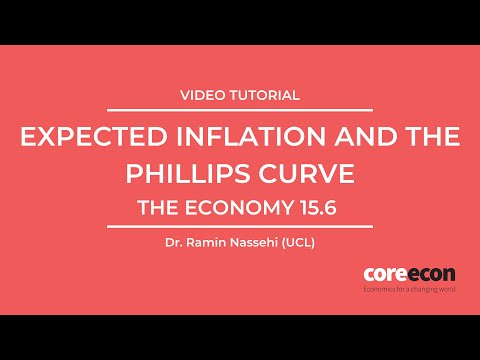

In [9]:
YouTubeVideo('j6YXY3zNmsM')

## Now the Simulator
We can throw some math formulas over here like $f(x^2)$ or centered ones like
$$Q(P)=\alpha-\beta \times P$$

In [12]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(
    SimEcon, 
    shock_type=widgets.Dropdown(options=['Demand','Supply'], value="Demand", description="Shock type:"),
    shock_size=widgets.IntSlider(1, 1,100,1, description="Shock size (%):", continuous_update=False),
)


print('Done')	


interactive(children=(Dropdown(description='Shock type:', options=('Demand', 'Supply'), value='Demand'), IntSl…

Done
